# Анализ источников новостей

Цель данного исследования: проанализировать источники новостных лент, сравнить рубрики, подумать над возможностью добавление\удаление категорий для проекта "Радар новостей рунета"

In [0]:
import numpy as np
import pandas as pd
import datetime as DT
import matplotlib.pyplot as plt

In [0]:
import itertools
from collections import Counter
from string import punctuation

In [0]:
from razdel import tokenize

## Датасет interfax. Предварительная обработка

Загрузим датасет intefax. Одновременно сделаем преобразование даты из строки

In [0]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [9]:
data_interfax = pd.read_csv('../data/interfax.csv',
                      sep=',',
                      index_col=False,
                      escapechar='\\',
                      parse_dates=['date'],
                      date_parser=dateparse,
                      quotechar='\"',
                      error_bad_lines=False)

b'Skipping line 158938: expected 17 fields, saw 20\n'
b'Skipping line 176941: expected 17 fields, saw 20\n'
b'Skipping line 280155: expected 17 fields, saw 23\n'


In [10]:
# Проверим преобразование
data_interfax.dtypes

date           datetime64[ns]
url                    object
edition                object
topics                 object
authors                object
title                  object
text                   object
reposts_fb             object
reposts_vk             object
reposts_ok             object
reposts_twi            object
reposts_lj             object
reposts_tg             object
likes                  object
views                  object
comm_count             object
dtype: object

In [11]:
data_interfax.shape

(543961, 16)

In [12]:
# Так выглядет датасет
data_interfax.head()

,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2019-04-30 13:26:00,https://www.sport-interfax.ru/659837,www.sport-interfax.ru,Спорт,NaN,Российского чемпиона мира по греко-римской бор...,Москва. 30 апреля. INTERFAX.RU - Чемпион мира ...,-,-,-,-,-,-,-,-,-
1,2019-05-07 12:46:00,https://www.sport-interfax.ru/660425,www.sport-interfax.ru,Спорт,NaN,Первый канал покажет все матчи россиян на ЧМ п...,Москва. 7 мая. INTERFAX.RU - Первый канал объя...,-,-,-,-,-,-,-,-,-
2,2019-05-08 12:57:00,https://www.sport-interfax.ru/660543,www.sport-interfax.ru,Спорт,NaN,Семак выразил надежду на новый контракт Кокори...,Москва. 8 мая. INTERFAX.RU - Главный тренер пе...,-,-,-,-,-,-,-,-,-
3,2019-05-09 00:06:00,https://www.sport-interfax.ru/660618,www.sport-interfax.ru,Спорт,NaN,"""Тоттенхэм"" стал вторым финалистом Лиги чемпионов",В финале он сыграет с другим представителем Ан...,-,-,-,-,-,-,-,-,-
4,2019-05-14 14:32:00,https://www.sport-interfax.ru/661091,www.sport-interfax.ru,Спорт,NaN,Претендовавшего на участие в ОИ скейтбордиста ...,Москва. 14 мая. INTERFAX.RU - Российский скейт...,-,-,-,-,-,-,-,-,-


In [13]:
# Выясним в каким столбцах есть пустые данные
data_interfax.isnull().any()

date           False
url            False
edition        False
topics         False
authors         True
title          False
text           False
reposts_fb     False
reposts_vk     False
reposts_ok     False
reposts_twi    False
reposts_lj     False
reposts_tg     False
likes          False
views          False
comm_count     False
dtype: bool

Как видим, в некоторых столбцах вместо значения Nan используется "-", их преобразованием займемся позже. А пока посмотрим строки, в которых пустые тексты новостей

In [15]:
print('Кол-во строк с значением NaN в столбце "authors" = ', data_interfax['authors'].isnull().sum())
data_interfax[data_interfax['authors'].isnull()].head()

Кол-во строк с значением NaN в столбце "authors" =  521464


,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2019-04-30 13:26:00,https://www.sport-interfax.ru/659837,www.sport-interfax.ru,Спорт,NaN,Российского чемпиона мира по греко-римской бор...,Москва. 30 апреля. INTERFAX.RU - Чемпион мира ...,-,-,-,-,-,-,-,-,-
1,2019-05-07 12:46:00,https://www.sport-interfax.ru/660425,www.sport-interfax.ru,Спорт,NaN,Первый канал покажет все матчи россиян на ЧМ п...,Москва. 7 мая. INTERFAX.RU - Первый канал объя...,-,-,-,-,-,-,-,-,-
2,2019-05-08 12:57:00,https://www.sport-interfax.ru/660543,www.sport-interfax.ru,Спорт,NaN,Семак выразил надежду на новый контракт Кокори...,Москва. 8 мая. INTERFAX.RU - Главный тренер пе...,-,-,-,-,-,-,-,-,-
3,2019-05-09 00:06:00,https://www.sport-interfax.ru/660618,www.sport-interfax.ru,Спорт,NaN,"""Тоттенхэм"" стал вторым финалистом Лиги чемпионов",В финале он сыграет с другим представителем Ан...,-,-,-,-,-,-,-,-,-
4,2019-05-14 14:32:00,https://www.sport-interfax.ru/661091,www.sport-interfax.ru,Спорт,NaN,Претендовавшего на участие в ОИ скейтбордиста ...,Москва. 14 мая. INTERFAX.RU - Российский скейт...,-,-,-,-,-,-,-,-,-


In [16]:
print('authors: ',data_interfax['authors'].unique())

authors:  [nan 'Анна Нехаева' 'Наталия Богданова' '/Интерфакс, Алексей Козин/'
 '/Интерфакс/' '/Интерфакс, Алиса Чудакова/' '/Анатолий Гусев, Интерфакс/'
 '/Алексей Козин, Интерфакс/' '/Интерфакс, Иван Баранов/'
 '/Интерфакс, Анатолий Гусев/' '/Иван Баранов, Интерфакс/'
 '/Карина Мелкумян, Интерфакс/' '/Алиса Чудакова, Интерфакс/'
 '/Интерфакс, Карина Мелкумян/' '/Интерфакс, Владимир Кондратьев/'
 '/Интерфакс, Дарья Карпенко/' '/Интерфакс, Зауреш Данаева/'
 '/Дарья Карпенко, Интерфакс/' '/Владимир Кондратьев, Интерфакс/'
 '/Финмаркет, Интерфакс/' '/Интерфакс, Алиса Чудакова, Анатолий Гусев/'
 '/Финмаркет/' '/Алор, Интерфакс/' '/Зауреш Данаева, Интерфакс/'
 '/Алексей Козин/' '/Интерфакс, Владимир Кондратьев, Дарья Карпенко/'
 '/Интерфакс, Дарья Карпенко, Анатолий Гусев/'
 '/Интерфакс, Владимир Кондратьев, Анатолий Гусев/' '/IFX.RU/'
 '/Финмаркет, IFX.RU/' '/Инфобизнес/' '/GlobalStock, IFX.RU/'
 '/Интерфакс, IFX.RU/' '/Интерфакс, Финмаркет/' '/Росинвестпроект/'
 '/Борис Грозовский, Дмитр

Посмотрим, что в столбцах, которые содержат дефис, как обозначение пустых данных

In [0]:
def analysis_columns(columns):
    for column in columns:
        if column not in ['url', 'date', 'topics', 'authors', 'title', 'text']:
            yield(print(str(column) + ':', data_interfax[column].unique()))

In [18]:
data_columns = list(analysis_columns(data_interfax.columns))

edition: ['www.sport-interfax.ru' '-']
reposts_fb: ['-']
reposts_vk: ['-']
reposts_ok: ['-']
reposts_twi: ['-']
reposts_lj: ['-']
reposts_tg: ['-']
likes: ['-']
views: ['-']
comm_count: ['-']


In [19]:
#  Проверим повторяющиеся тексты
print('Кол-во одинаковых текстов:',data_interfax.text.duplicated().sum())

Кол-во одинаковых текстов: 241


In [0]:
data_interfax = data_interfax.drop_duplicates(subset='text')

In [21]:
data_interfax.shape

(543720, 16)

## EDA

### Анализ дат

In [22]:
print('Минимальная дата в датасете:', data_interfax.date.min())
print('Максимальная дата в датасете:', data_interfax.date.max())

Минимальная дата в датасете: 2008-02-11 03:47:00
Максимальная дата в датасете: 2019-05-27 08:09:00


#### Распределение количества новостей по месяцам

In [0]:
# Вынесем месяц и год новости в отдельные столбцы
data_interfax['month'] = data_interfax.date.apply(lambda x: x.month)
data_interfax['year'] = data_interfax.date.apply(lambda x: x.year)

# Создадим отдельный датасет посчитаем количество новостей в разрезе месяца и года
df = data_interfax.groupby(['year', 'month']).text.nunique().reset_index()

In [24]:
df.head()

,year,month,text
0,2008,2,1053
1,2008,3,3263
2,2008,4,3333
3,2008,5,3142
4,2008,6,3104


In [0]:
df['month_year'] = df[['month', 'year']].apply(lambda x: '-'.join(['0'+str(x.month) if x.month<10 else str(x.month),
                                                                  str(x.year)]),
                                               axis =1)

In [0]:
df.columns = ['year', 'month', 'nunique_text', 'month_year']

In [0]:
# выберем только те месяцы, в которых количество новостей больше 10
df = df[df.nunique_text>10]

In [28]:
df[['month_year', 'nunique_text']].sort_values('nunique_text', ascending = False).head()

,month_year,nunique_text
89,07-2015,5484
72,02-2014,5402
73,03-2014,5372
85,03-2015,5307
86,04-2015,5285


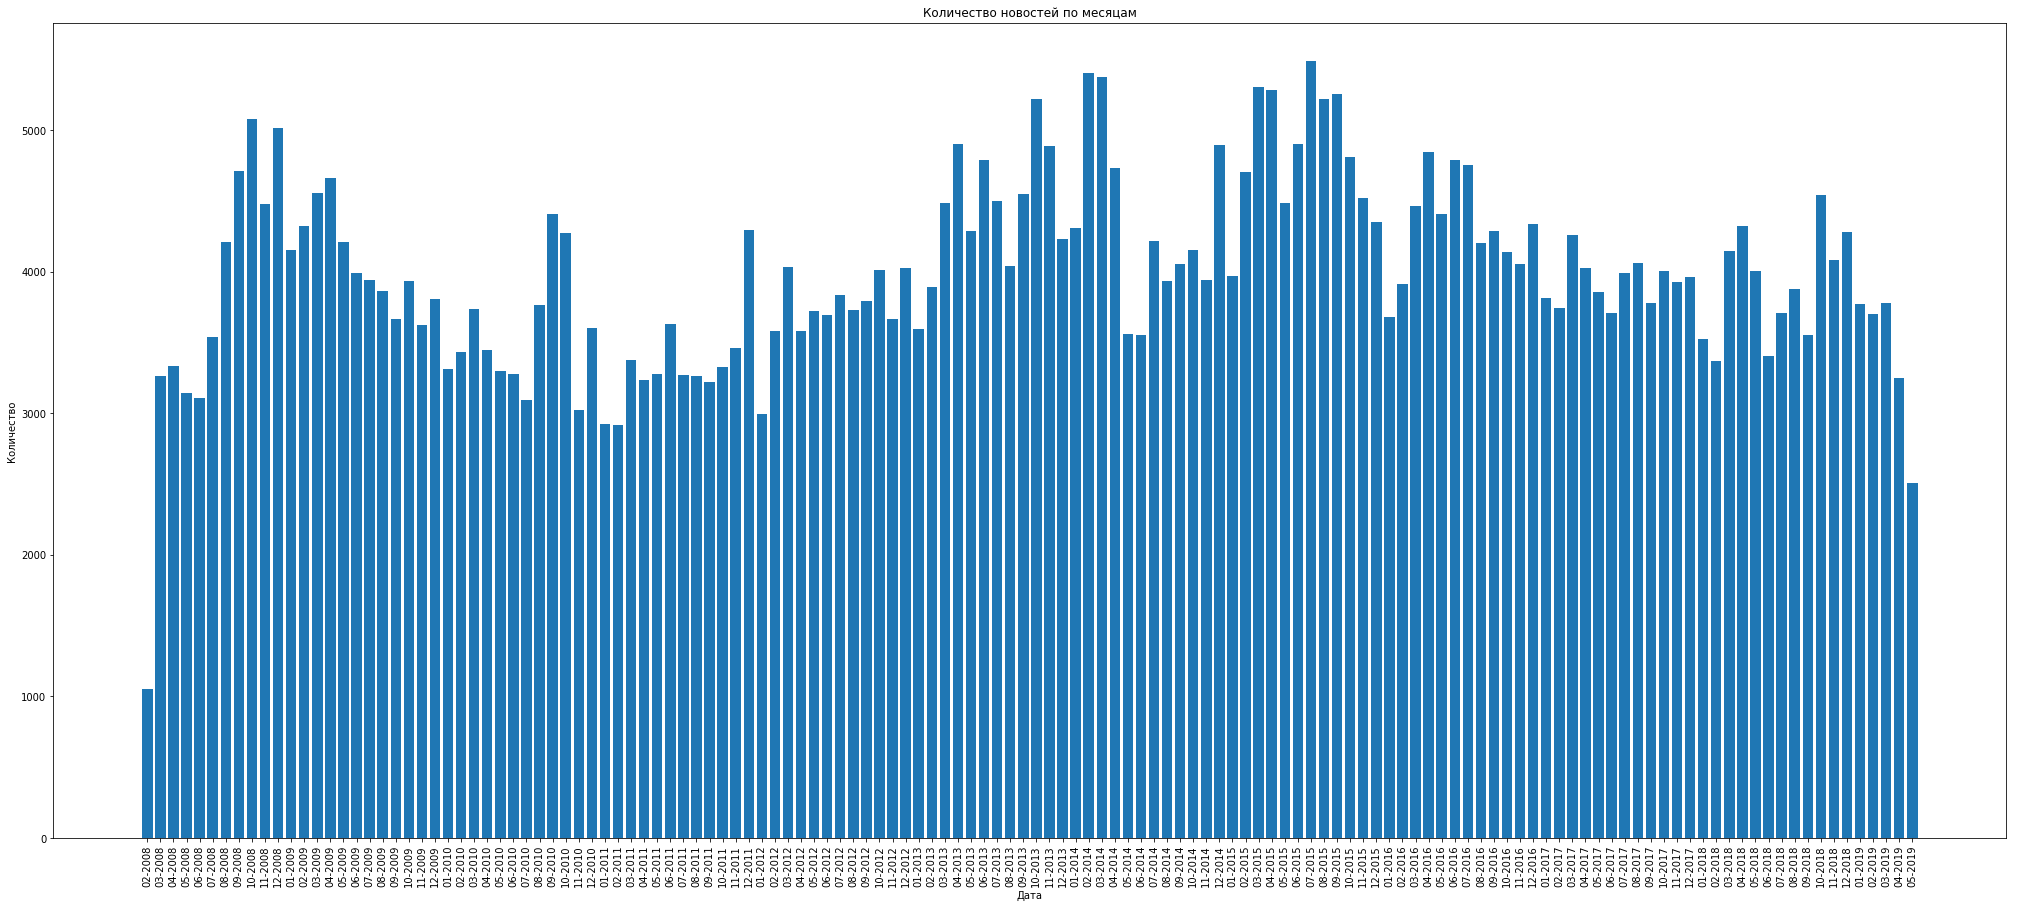

In [29]:
fig, ax = plt.subplots(figsize=(35, 15))
plt.bar(x = df.month_year,
        height = df.nunique_text.values)
plt.xticks(rotation='vertical')
ax.set_title('Количество новостей по месяцам')
ax.set_ylabel('Количество')
ax.set_xlabel('Дата')
plt.show()

### Создание словаря для анализа

В данной части блокнота будет подготовлен словарь из всего множества слов во всем датасете. Для каждой новости будет выполнена токенизация. Затем будет собран словарь из всех токенов, очистка от знаков препинания, и после данных процедур создается два списка - один без удаления стоп-слов, второй с удалением. Анализ проводится по частоте вхождений для каждого списка

In [0]:
def create_dictionary(text):
    for news in text:
        tokens = list(tokenize(news.lower()))
        yield([_.text for _ in tokens])

In [31]:
news_tokenize = list(create_dictionary(data_interfax.text.values))
print('Done')

Done


In [0]:
# Соберем словарь из новостей для последующего анализа, без объединения повторяющихся слов
dictionary = list(itertools.chain.from_iterable(news_tokenize))

In [0]:
# Соберем значки препинания, часть возьмем из готовой библиотеки, часть добавим свои

In [0]:
punctuation = list(punctuation)

In [0]:
punctuation += ['«','»','—','n','»,','».', '–', '...']

In [0]:
garbage_words = ['nранее', 'nв', 'nпо', 'nтакже','u','n—', 'nn']

In [0]:
# Словарь без удаления стопслов
dictionary_with_stopwords = [item for item in dictionary if item not in punctuation]

In [0]:
dictionary_with_stopwords = [item for item in dictionary_with_stopwords if item not in garbage_words]

In [0]:
stopwords_01 = open('../nlp/preprocessing/stopwords.txt', 'r', encoding='UTF-8')
stopwords_01 = stopwords_01.read().split('\n')
stopwords_02 = open('../nlp/preprocessing/stopwords_02.txt', 'r', encoding='UTF-8')
stopwords_02 = stopwords_02.read().split('\n')

In [0]:
stopwords = stopwords_01 + stopwords_02

In [0]:
# Словарь после удаления стопслов
dictionary_without_stopwords = [item for item in dictionary_with_stopwords if item not in stopwords]

### Аналитика по словам

#### 20 самых популярных слов без удаления стопслов

In [46]:
Counter(dictionary_with_stopwords).most_common(20)

[('в', 4933106),
 ('и', 2100625),
 ('на', 2018423),
 ('по', 1240563),
 ('с', 1062207),
 ('что', 1061605),
 ('не', 791399),
 ('ru', 518918),
 ('interfax', 496998),
 ('москва', 459970),
 ('о', 453379),
 ('из', 415492),
 ('к', 412096),
 ('за', 369856),
 ('как', 362943),
 ('он', 358865),
 ('для', 336305),
 ('а', 317528),
 ('года', 312566),
 ('его', 301033)]

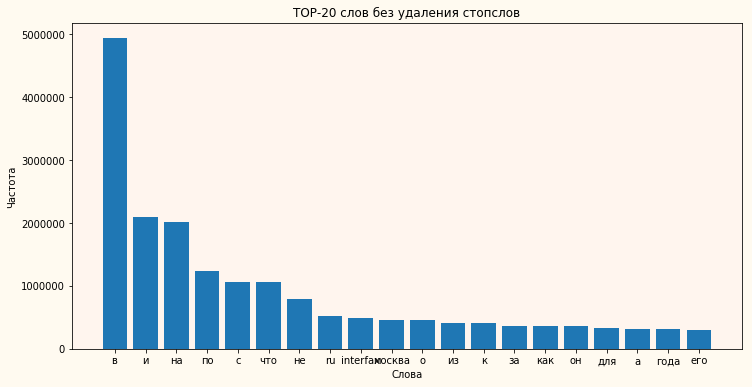

In [47]:
x = dict(Counter(dictionary_with_stopwords).most_common(20)).keys()
y = dict(Counter(dictionary_with_stopwords).most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов без удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure


plt.show()

#### 20 самых популярных слов после удаления стопслов

In [48]:
Counter(dictionary_without_stopwords).most_common(20)

[('ru', 518918),
 ('interfax', 496998),
 ('рф', 278846),
 ('россии', 271039),
 ('сообщил', 178777),
 ('сша', 163717),
 ('заявил', 159890),
 ('интерфаксу', 154084),
 ('словам', 148846),
 ('1', 130239),
 ('рублей', 122930),
 ('млрд', 118684),
 ('млн', 116121),
 ('отметил', 108415),
 ('данным', 106650),
 ('тыс', 103933),
 ('области', 102288),
 ('сообщает', 99088),
 ('сообщили', 98717),
 ('говорится', 96952)]

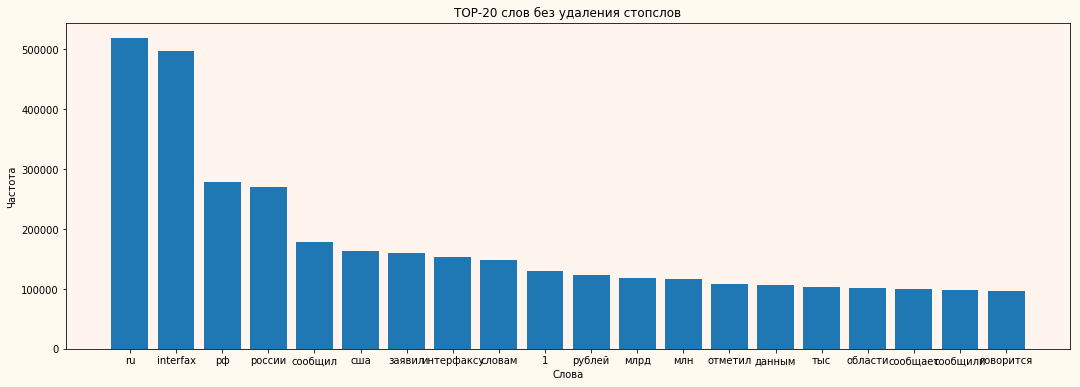

In [49]:
x = dict(Counter(dictionary_without_stopwords).most_common(20)).keys()
y = dict(Counter(dictionary_without_stopwords).most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов без удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(18)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure


plt.show()

### Рубрики interfax

In [50]:
# Считаем количество рубрик в данном датасете, а также выведем значения
print('Количество рубрик = ', data_interfax.topics.unique().shape)
data_interfax['topics'].unique()

Количество рубрик =  (8,)


array(['Спорт', 'В мире', 'В России', 'Москва', 'Экономика', 'Культура',
       'Интервью', 'Пресс-центр'], dtype=object)

Все рубрики, с количеством новостей в каждой группе

In [51]:
data_interfax.groupby('topics')['topics'].count()

topics
В России       285983
В мире         102923
Интервью          583
Культура        12759
Москва          18415
Пресс-центр        29
Спорт           42989
Экономика       80039
Name: topics, dtype: int64